# Query to reference mapping of the human endometrium

In this notebook, we will use scArches model surgery ([paper](https://www.nature.com/articles/s41587-021-01001-7), [github](https://github.com/theislab/scarches)) to map human endometrium scRNA-seq data our integrated atlas. This tutorial was adapted from the [fetal immune reference](https://github.com/Teichlab/Pan_fetal_immune/blob/master/tutorials/tutorial_query2reference_mapping.ipynb) and [scANVI](https://docs.scarches.org/en/latest/scanvi_surgery_pipeline.html) tutorials.

In this tutorial, our query dataset is three additional endometrial samples from [Huang et al, 2023](https://academic.oup.com/cei/article-abstract/212/3/285/7069119?redirectedFrom=fulltext). The three samples were published after the main analyssi for our paper was carried out, and therefore they were not included in the original reference model. However, it is important to note that because the reference model includes other samples from the same dataset, these samples may map more closely to the reference atlas than entirely new samples. 

The scVI model in our paper was trained using a variable with dataset name as the batch covariate, and the variable with sample ID (genotype) as an additional categorical covariate. The current version of scArches (0.5.9) does not suport the inclusion of additional categorical covariates, therefore for the purposes of this tutorial we trained a new scANVI model using sample ID (genotype) as batch covariate, and our fine-grained cell type annotations as cell tyep labels (note that each genotype is present in only one dataset). While this may slighlty modify the appearance of the UMAP (orientation of the different cell clusters), this does not affect result interpretation. 

In [ ]:
! pip install scarches==0.5.9
! pip install "pandas<2.0.0"

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

import scvi

import pandas as pd

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Load data

The reference data can be downloaded from [Reproductive Cell Atlas](https://www.reproductivecellatlas.org/endometrium_reference.html)

In [7]:
# ref_adata = sc.read_h5ad("/nfs/team292/mm58/HECA/cellxgene_objects/endometriumAtlasV2_cells_with_counts.h5ad")
ref_adata = sc.read_h5ad("/path/to/data.h5ad")

In [10]:
# cellxgene object has normalized data in slot X
# bring back raw counts
ref_adata.X = ref_adata.layers["counts"]

In [11]:
# Subset to highly variable genes
ref_adata = ref_adata[:, ref_adata.var.highly_variable].copy()

Before mapping to the reference data, we need to run a few checks:
* scVI uses raw counts as input, we need to check query_adata.X is raw counts
* our model uses gene names as variable names, we need to check that query_adata.var_names corresponds to gene names

In this tutorial, we are using samples GSM7277296, GSM7277297, GSM7277298 from Gene Expression Omnibus (accession code [GSE214411](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE214411)). The raw data was processed according to the Methods described in the HECA paper.

In [12]:
query_adata = sc.read_h5ad('../data/Huang_counts.h5ad')

In [15]:
def _verify_counts(adata):
    return(all([not (i%1) for i in adata.X[0,:].toarray()[0]]))

if not _verify_counts(query_adata):
    raise ValueError('`target_adata.X` does not contain raw counts.')
    
if query_adata.var_names.str.startswith("ENS").all():
    raise ValueError('`target_adata.var_names` are Ensembl geneIDs. Please convert')

## Create scANVI model and train on fully labelled reference dataset

In [16]:
## Set up - set anndata batch and cell type variables
condition_key = 'genotype'
cell_type_key = 'celltype'


In [17]:
## Train scANVI model from scVI model 
## This step does not need to be repeated if you are downloading scanvi model weights 
## and is included purely for reproducibility

# sca.models.SCVI.setup_anndata(ref_adata, batch_key=condition_key, labels_key=cell_type_key)

# vae = sca.models.SCVI(
#     ref_adata,
#     n_layers=2,
#     encode_covariates=True,
#     deeply_inject_covariates=False,
#     use_layer_norm="both",
#     use_batch_norm="none",
# )

# vae.train()

# scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

# print("Labelled Indices: ", len(scanvae._labeled_indices))
# print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

# scanvae.train(max_epochs=20)

In [18]:
###### TO UPDATE - code for downloading model

In [19]:
# UPDATE MODEL NAME HERE : heca_scanvi
ref_path = "scanvi_ref_filtered/"
scanvae = sca.models.SCANVI.load(ref_path, ref_adata)

INFO     File scanvi_ref_filtered/model.pt already downloaded                                                      


## Perform surgery on reference model and train on query dataset without cell type labels


In [20]:
# Set up query anndata 

sca.models.SCANVI.prepare_query_anndata(query_adata, scanvae)
query_adata.obs[cell_type_key] = scanvae.unlabeled_category_

INFO     Found 99.5% reference vars in query data.                                                                 


In [22]:
model = sca.models.SCANVI.load_query_data(
    query_adata,
    ref_path,
    freeze_dropout = True,
)

model._unlabeled_indices = np.arange(query_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))


INFO     File scanvi_ref_filtered/model.pt already downloaded                                                      
Labelled Indices:  0
Unlabelled Indices:  21495


In [23]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

In [57]:
# # Save model for future use
surgery_path = 'model_surgery' # "scanvi_surgery_model_filtered"
model.save(surgery_path, overwrite=True)

In [24]:
# code to reload the model after training:
# model = scvi.model.SCANVI.load(surgery_path, query_adata)

INFO     File scanvi_surgery_model_filtered/model.pt already downloaded                                            


### Get latent representations and visualize

In [25]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['celltype'] = query_adata.obs[cell_type_key].tolist()
query_latent.obs['genotype'] = query_adata.obs[condition_key].tolist()

In [26]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent, min_dist=0.4)


/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/d

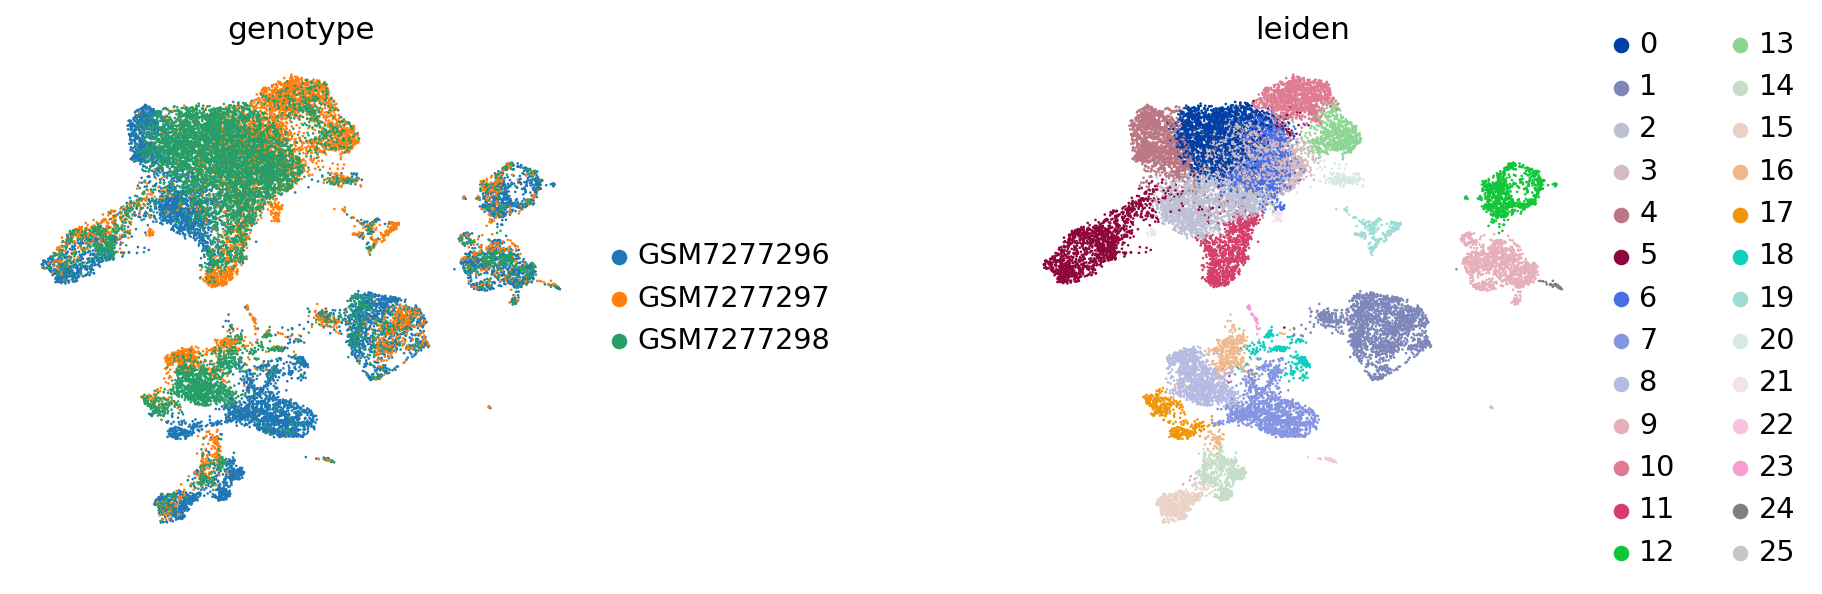

In [27]:
sc.pl.umap(
    query_latent,
    color=["genotype", "leiden"],
    frameon=False,
    wspace=0.6,
)

### Marker gene visualization

In [28]:
## add leiden clusters to query anndata object with raw counts 
query_adata.obs["leiden"] = query_latent.obs["leiden"].tolist()

In [29]:
## store counts in raw layes 
query_adata.layers['counts']=query_adata.X.copy() 

In [30]:
## normalize and log transform
sc.pp.normalize_total(query_adata, target_sum=1e4)
sc.pp.log1p(query_adata)

In [31]:
def filter_genes(marker_dict, adata = query_adata):
    """
    Filter a list of marker genes to only keep those present in adata varnames
    """
    filtered_dict = {}
    
    gene_names = adata.var_names.tolist()
    
    for key, value in marker_dict.items():
        filtered_genes = value.intersection(gene_names)
        if len(filtered_genes) > 0:
            filtered_dict[key] = filtered_genes
        else:
            print("No gene founds for", key)
        
    return filtered_dict

In [32]:
lineage_markers = {"Endothelial" : {"CDH5", "VWF"},
                  "Epithelial" : {"EPCAM", "PAX8"},
                  "Immune" : {"PTPRC", "CD3D", "NKG7", "CSF1R"},
                  "Mensechymal" : {"PCOLCE", "DCN", "COL1A1"}}

In [33]:
lineage_markers = filter_genes(lineage_markers)

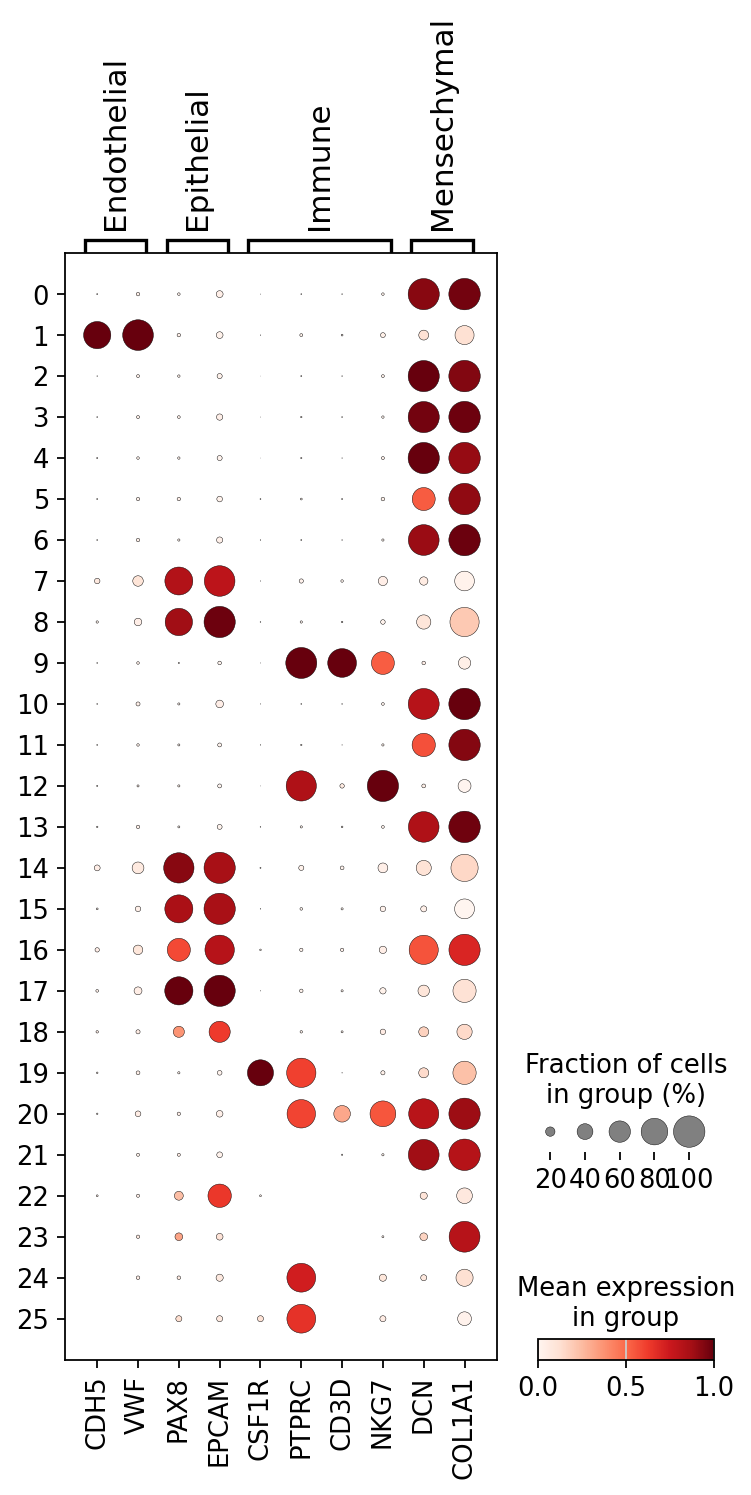

In [34]:
sc.pl.dotplot(query_adata, lineage_markers, groupby = "leiden", standard_scale = "var" )

In [35]:
cluster_lineage = {"Endothelial" : ["1"],
                  "Epithelial" : ["7", "8", "14", "15", "16", "17", "18", "22"],
                  "Immune" : ["9", "12", "19", "24", "25"],
                  "Mesenchymal" : ["0", "2", "3", "4", "5", "6", "10", "11", "13", "20", "21", "23"]}

In [36]:
query_latent.obs["lineage"] = query_latent.obs["leiden"].map({value: category for category, values in cluster_lineage.items() for value in values})

In [37]:
query_adata.obs["lineage"] = query_latent.obs["lineage"].tolist()

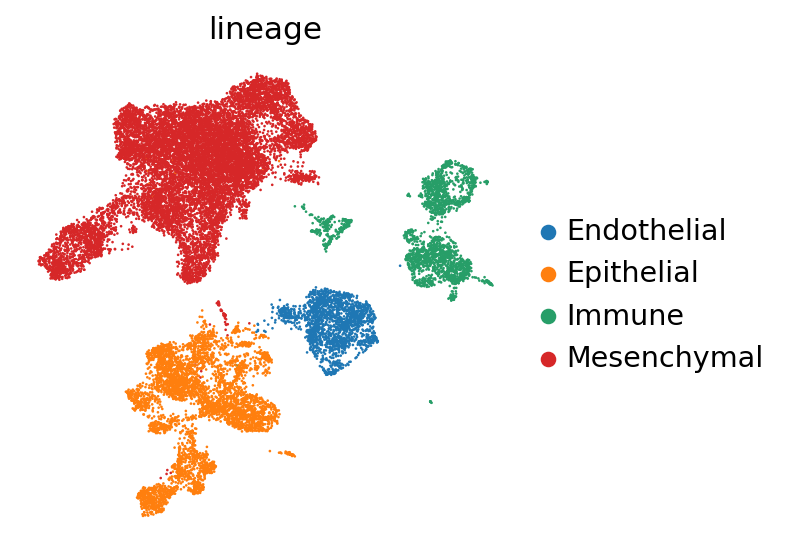

In [38]:
sc.pl.umap(
    query_latent,
    color="lineage",
    frameon=False,
    wspace=0.6,
)

## Get latent representation of reference + query dataset and compute UMAP


In [58]:
# Harmonize metadata columns before merging
query_adata.obs["dataset"] = "Huang_new" 
query_adata.obs["celltype"] = "Unknown"

# match the numbering and formating of Fig 1 in the paper
query_adata.obs["Symbol"] = "37"
query_adata.obs["label_long"] = "37 | Huang new samples"  

In [59]:
## restore counts 
query_adata.X = query_adata.layers['counts']

In [61]:
adata_full = ref_adata.concatenate(query_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['celltype'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['genotype'] = adata_full.obs[condition_key].tolist()
full_latent.obs["dataset"] = adata_full.obs["dataset"].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [97]:
# add colors for plotting
full_latent.obs['label_long'] = adata_full.obs['label_long'].tolist()
full_latent.uns['label_long_colors'] = ref_adata.uns['label_long_colors'].tolist() + ["#3D3D3D"]
full_latent.obs['Symbol'] = adata_full.obs['Symbol'].tolist()

In [98]:
full_latent.uns['Symbol_colors'] = ref_adata.uns['Symbol_colors'].tolist() + ["#3D3D3D"]

In [65]:
sc.pp.neighbors(full_latent)
sc.tl.umap(full_latent, min_dist = 0.4)

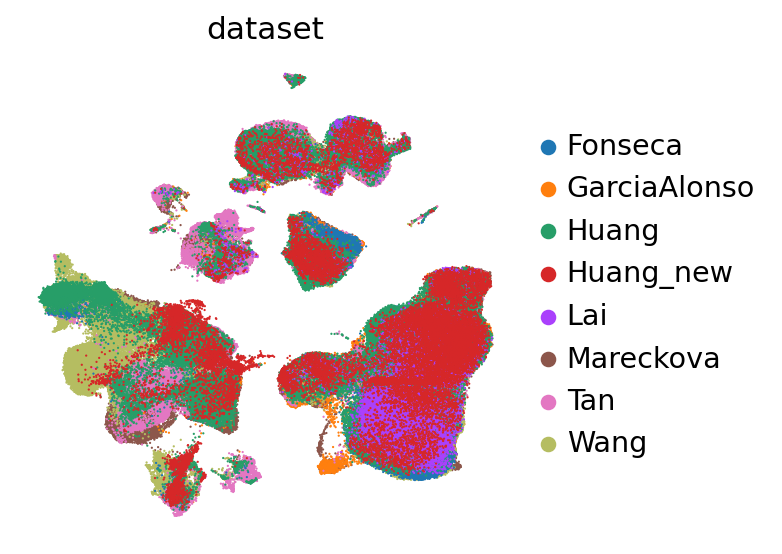

In [66]:
sc.pl.umap(full_latent,
           color=['dataset'],
           frameon=False,
           wspace=0.6, size = 4)

In [67]:
full_latent.obs["huang_viz"] = np.where(full_latent.obs["dataset"] == "Huang_new", 
                                        full_latent.obs["dataset"], 
                                        np.nan)

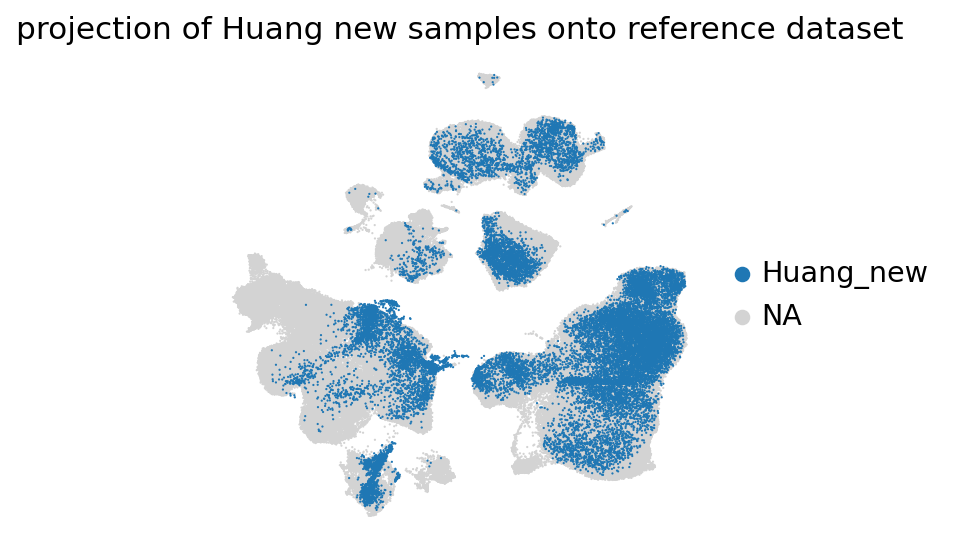

In [68]:
sc.pl.umap(full_latent,
           color=['huang_viz'],
           frameon=False,
           wspace=0.6, size = 4, 
           title="projection of Huang new samples onto reference dataset")

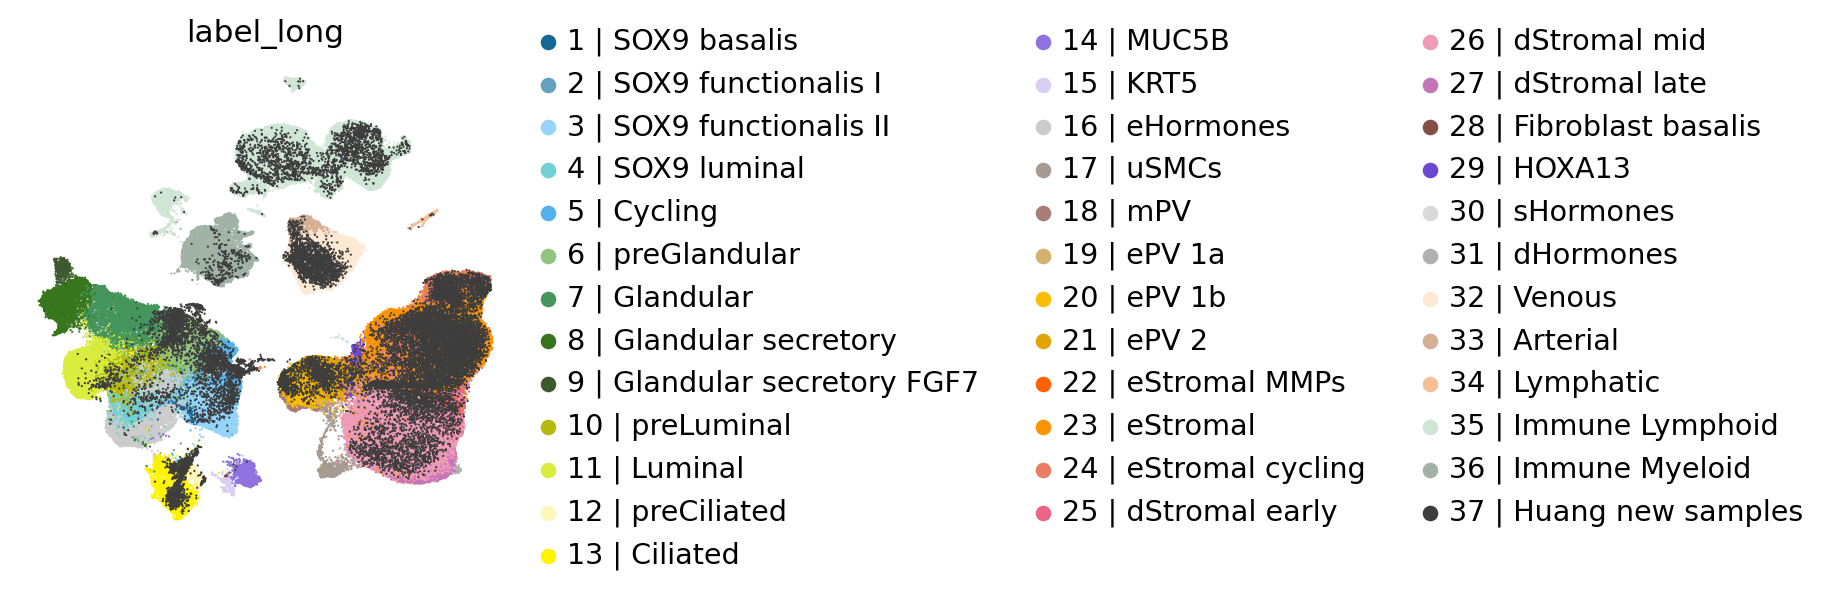

In [99]:
sc.pl.umap(full_latent,
           color=['label_long'],
           frameon=False,
           wspace=0.6, size = 4)

In [70]:
full_latent.obs.index = adata_full.obs.index

In [109]:
query_latent.obs["lineage_cl"] = query_latent.obs["lineage"].astype(str) + "_" + query_latent.obs["leiden"].astype(str)

In [110]:
query_latent.obs.index = query_adata.obs.index.to_list()

In [111]:
# match index format in full_latent joint anndata object
query_latent.obs["index_u"] = query_latent.obs.index + "-1"

In [114]:
full_latent.obs = full_latent.obs.join(query_latent.obs.set_index("index_u")[["manual_label", "lineage_cl"]])

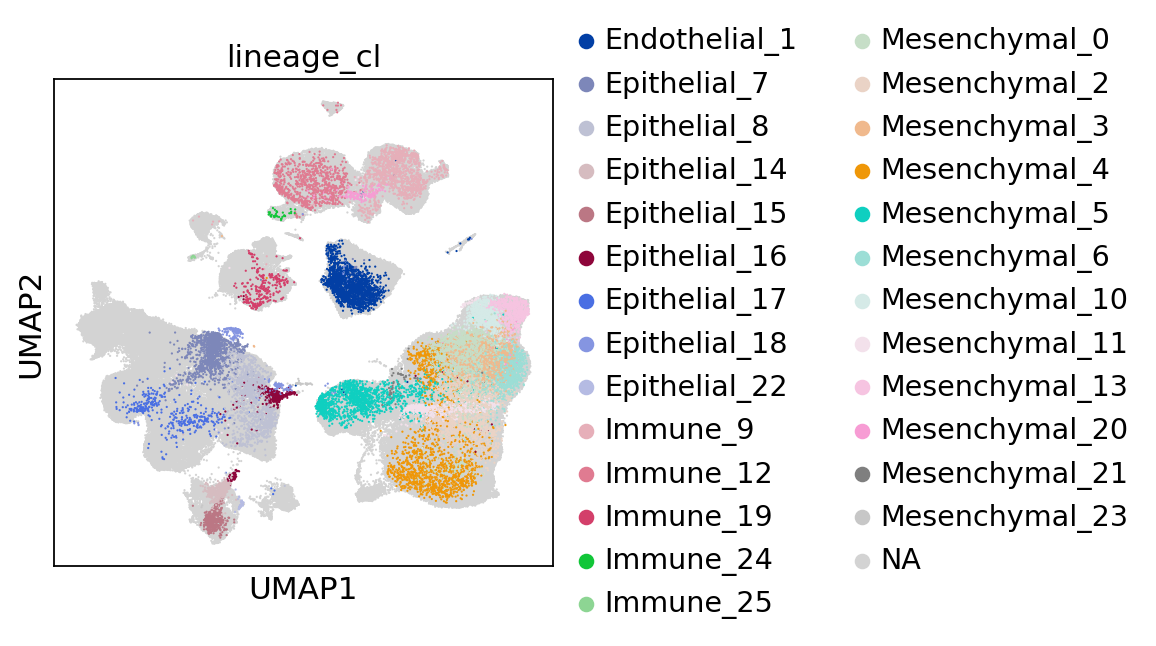

In [115]:
sc.pl.umap(full_latent, 
          color = "lineage_cl", 
          size = 4)

## Compare expression of marker genes

In [144]:
def filter_by_lineage(adata, lineage):
    """
    
    1. filter joint dataset based on input lineage
    2. reorder "ct_merged" variable for plotting
    
    """
    
    
    adata_filter = adata_full[(adata_full.obs["lineage_merged"] == lineage), :]
    
    # Reorder for plotting 
    # the query dataset cells are Lineage_cluster
    # group all the query cells together
    ct_ordered = adata_filter.obs["ct_merged"].unique().tolist()
    ct_ordered = sorted([i for i in ct_ordered if lineage + "_" in i]) + sorted([i for i in ct_ordered if lineage + "_" not in i])

    adata_filter.obs["ct_merged"] = adata_filter.obs["ct_merged"].astype("category").cat.reorder_categories(ct_ordered)
    
    return adata_filter


In [120]:
adata_full.obs = adata_full.obs.join(query_latent.obs.set_index("index_u").rename(columns = {"lineage" : "manual_lineage"})[["manual_lineage", "lineage_cl"]])

adata_full.obs["lineage_merged"] = np.where(adata_full.obs["dataset"] == "Huang_new", 
                                            adata_full.obs["manual_lineage"], 
                                            adata_full.obs["lineage"])

adata_full.obs["ct_merged"] = np.where(adata_full.obs["dataset"] == "Huang_new", 
                                            adata_full.obs["lineage_cl"], 
                                            adata_full.obs["celltype"])


In [39]:
epithelial_markers = {
    'Epithelial':{'EPCAM','PAX8'},
    'Glandular group':{'FOXA2'},
    'SOX9-MMP7':{'SOX9','MMP7'},
    'SOX9 basalis (CDH2+)':{'KLK11', 'AXIN2', 'ALDH1A1','TRH','CDH2'}, # 'FUT4',
    'SOX9 functionalis I (CDH2+)':{'SLC7A11', 'DKK1', 'PHLDA1'}, #,'CREB5'
    'SOX9 functionalis II':{'IHH','KMO','EMID1'}, # 'GUSB is also good,
    'preGlandular':{'SUFU', 'CBR3', 'OPRK1','HPRT1'}, # 'TENM2',
    'Glandular': {'SCGB2A2', 'S100P','ABCG1'}, # 'SSP1',
    'Glandular secretory': {'DPP4', 'PAEP','GPX3'}, # , 'TBXAS1'
    'Glandular secretory (FGF7+)': {'FGF7', 'FXYD2', 'PTPRR'}, #'TSPAN8'
    'SOX9 luminal (LGR5+)':{'IL32', 'WNT7A', 'TNF','MMP7','LGR5'},
    'preLuminal':{'SULT1E1','VTCN1','CLDN22'},
    'Luminal':{'LEFTY1', 'PTGS1', 'LGR5', 'IL6'},
    'preCiliated':{'MUC12', 'CDC20B', 'CCNO'},
    'Ciliated': {'PIFO', 'FOXJ1', 'TP73'},
    'MUC5B':{'MUC5B', 'TFF3', 'SAA1','BPIFB1'},
    'KRT5':{'KRT5', 'TP63', 'SNCG'},
    'Steroid receptors':{'PGR', 'ESR1','AR'},
}

In [122]:
epithelial_markers = filter_genes(epithelial_markers, adata_full)

In [125]:
epithelial_full = filter_by_lineage(adata_full, "Epithelial")

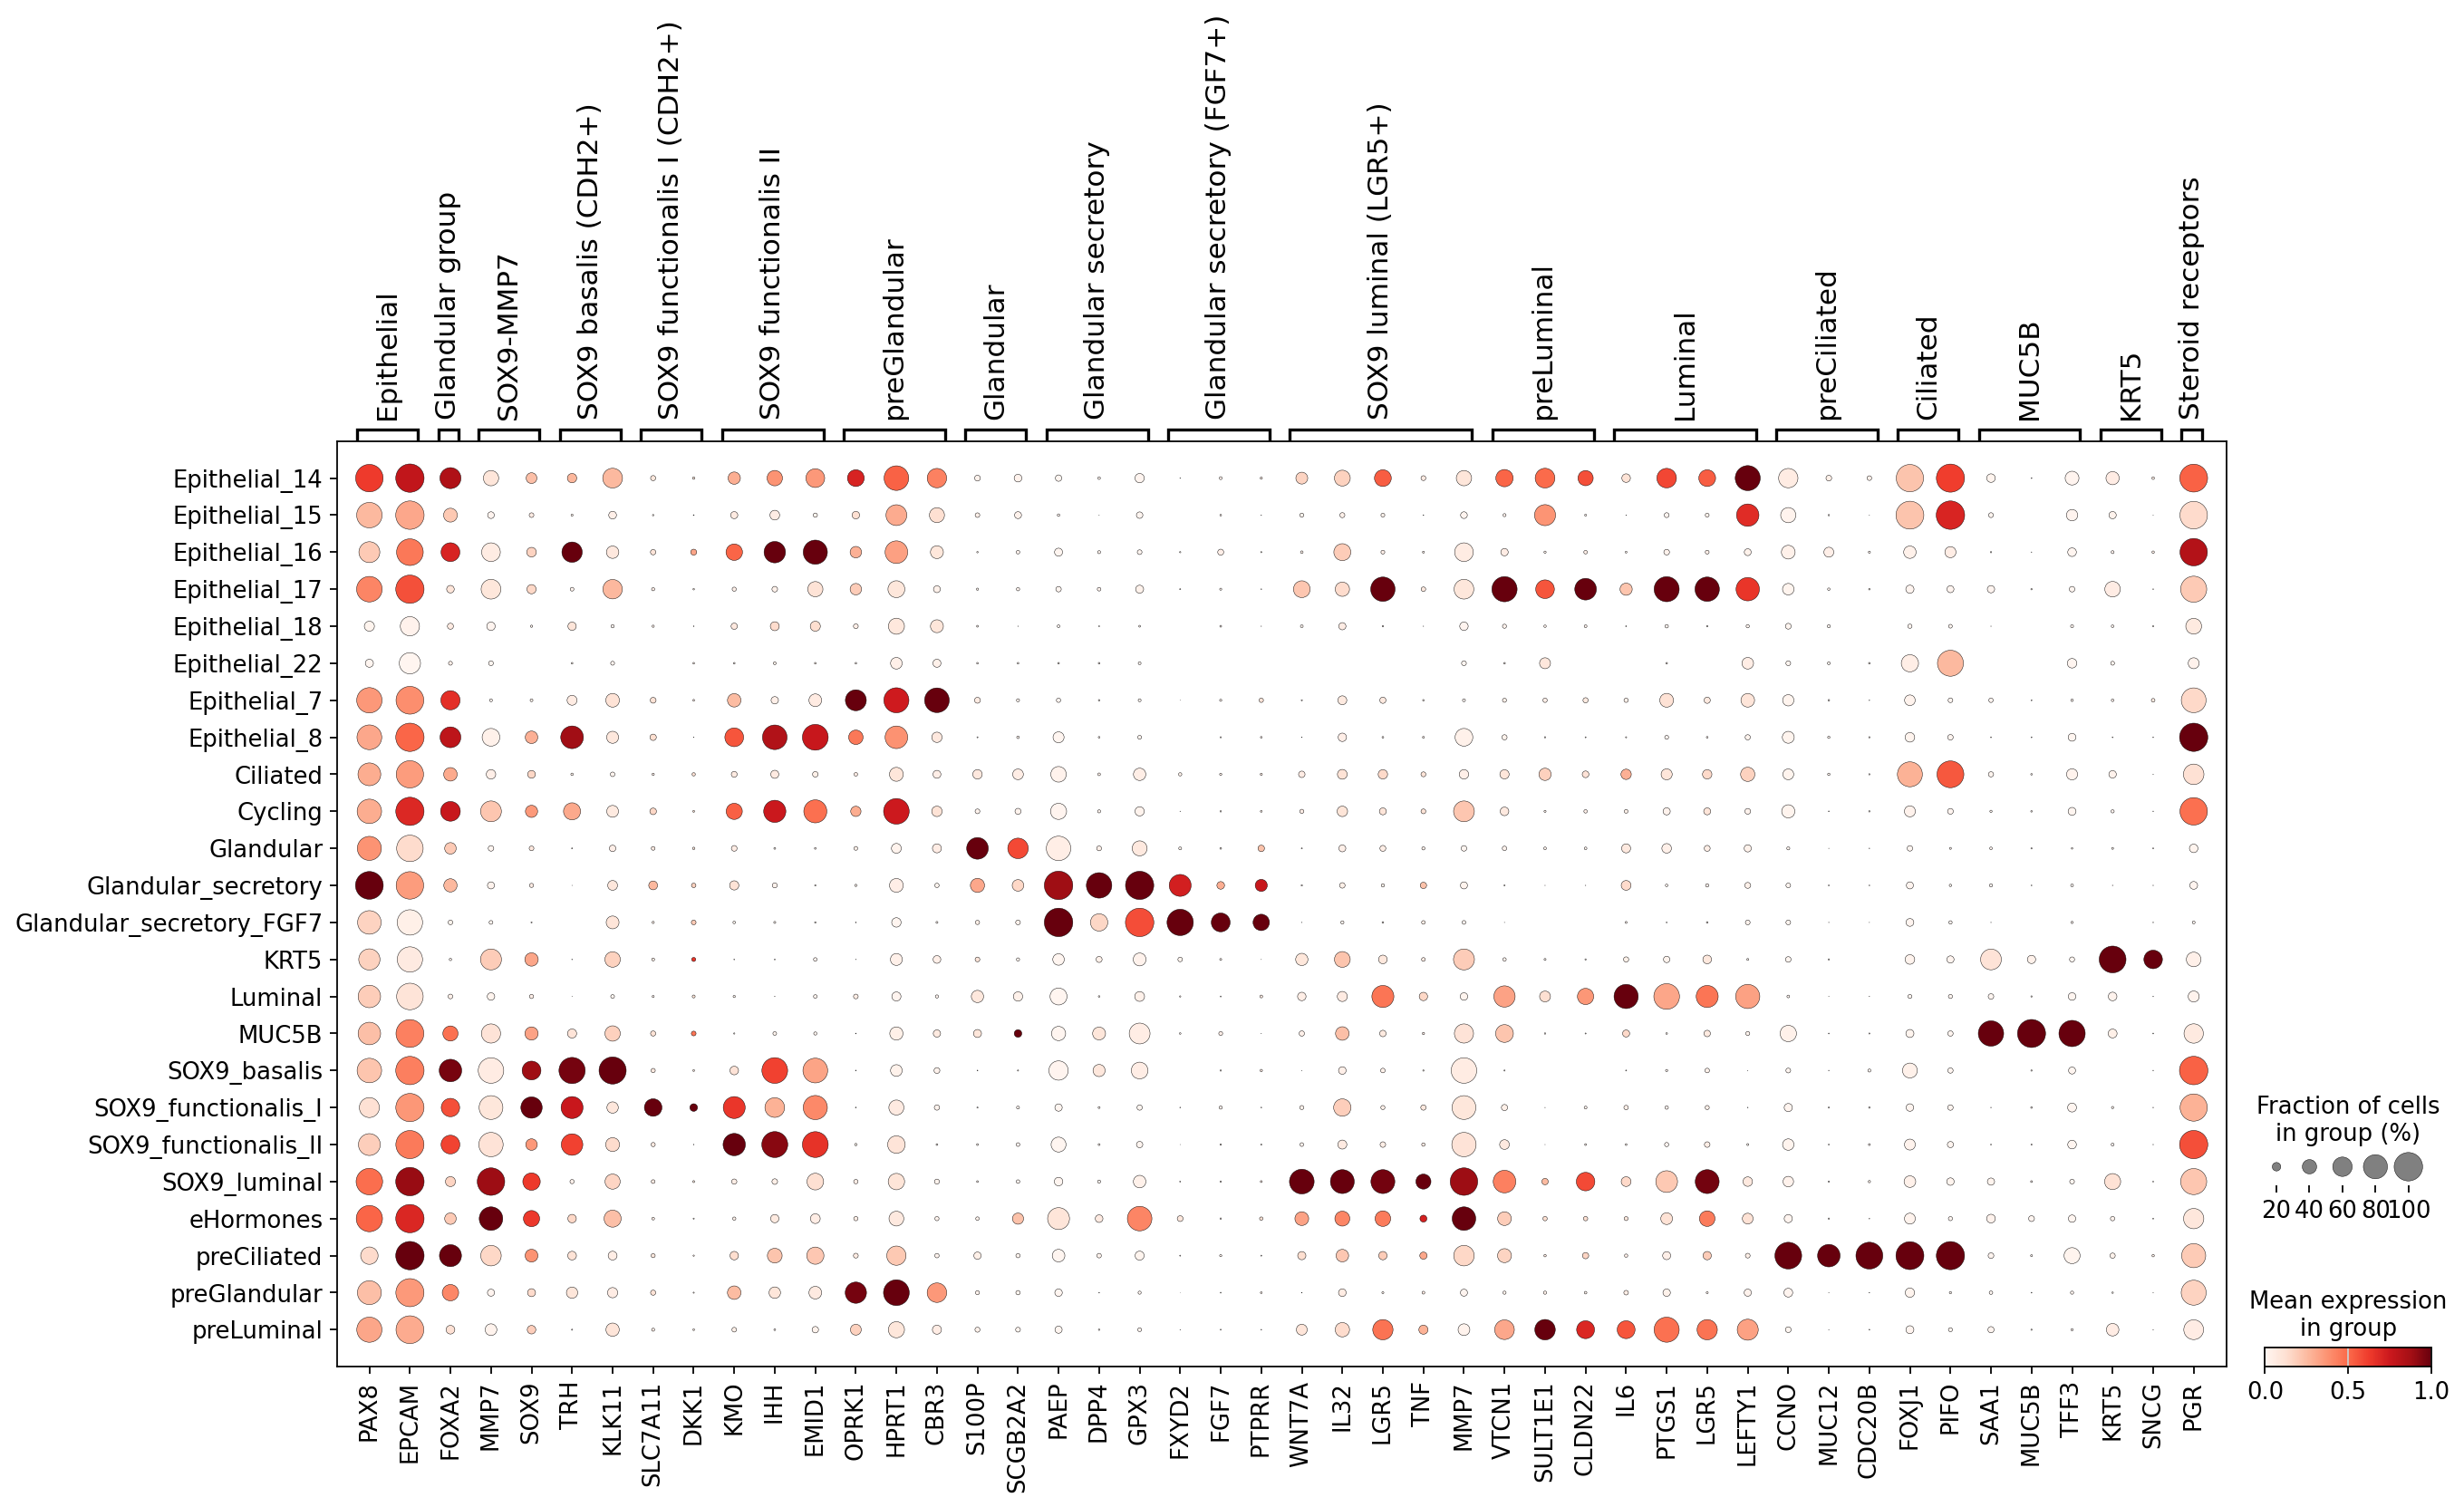

In [136]:
### Epithelial

sc.pl.dotplot(
    epithelial_full, 
    epithelial_markers, 
    groupby = "ct_merged", 
    standard_scale = "var"
)             

In [43]:
mesen_markers = {
    'Mesenchymal_general':{'PCOLCE','DCN'},
    'uSMCs':{'ACTG2', 'DES','PTGER3'}, # 'PCP4', 'PTGER2',
    'Perivascular_general':{'RGS5'},
    'ePV-1a (STEAP4+)':{'STEAP4', 'SSTR2', 'SMTNL2'}, # 'ARHGAP15',
    'ePV-2b (STC2+)':{'SLC38A11','MYOM2','STC2'}, # 'NTRK2', 'NET1', 'MAP3K7CL', 'NRARP',
    'ePV-2 (MMP11+)':{'MMP11', 'TDO2', 'CYGB'},
    'Stromal_general':{'PDGFRA'},
    'Stromal_progenitor':{'SUSD2','MCAM','PDGFRB'},
    'eStromal':{'MMP11', 'CRABP2','TUNAR', 'FOXL2', 'TGFBI', 'F13A1'},
    'eStromal MMPs':{'INHBA', 'MMP10','MMP3', 'MMP1', 'COL8A1'}, # 'BMP2',
    'dStromal early':{'CILP', 'CALB2', 'PCSK6', 'TPPP3','PLCL1'},
    'dStromal mid':{'SCARA5', 'CXCL13', 'GABRA2', 'TLR4'},
    'dStromal late':{'SMAD7','CXCL8', 'CXCL2','TRIB1', 'LEFTY2'},
    'Fibroblast basalis': {'C7', 'PTGIS'}, # 'SCN7A',
    'Steroid receptors':{'PGR', 'ESR1','AR'} 
}

In [44]:
mesen_markers = filter_genes(mesen_markers, adata_full)

No gene founds for Stromal_general


In [147]:
mesen_full = filter_by_lineage(adata_full, "Mesenchymal")

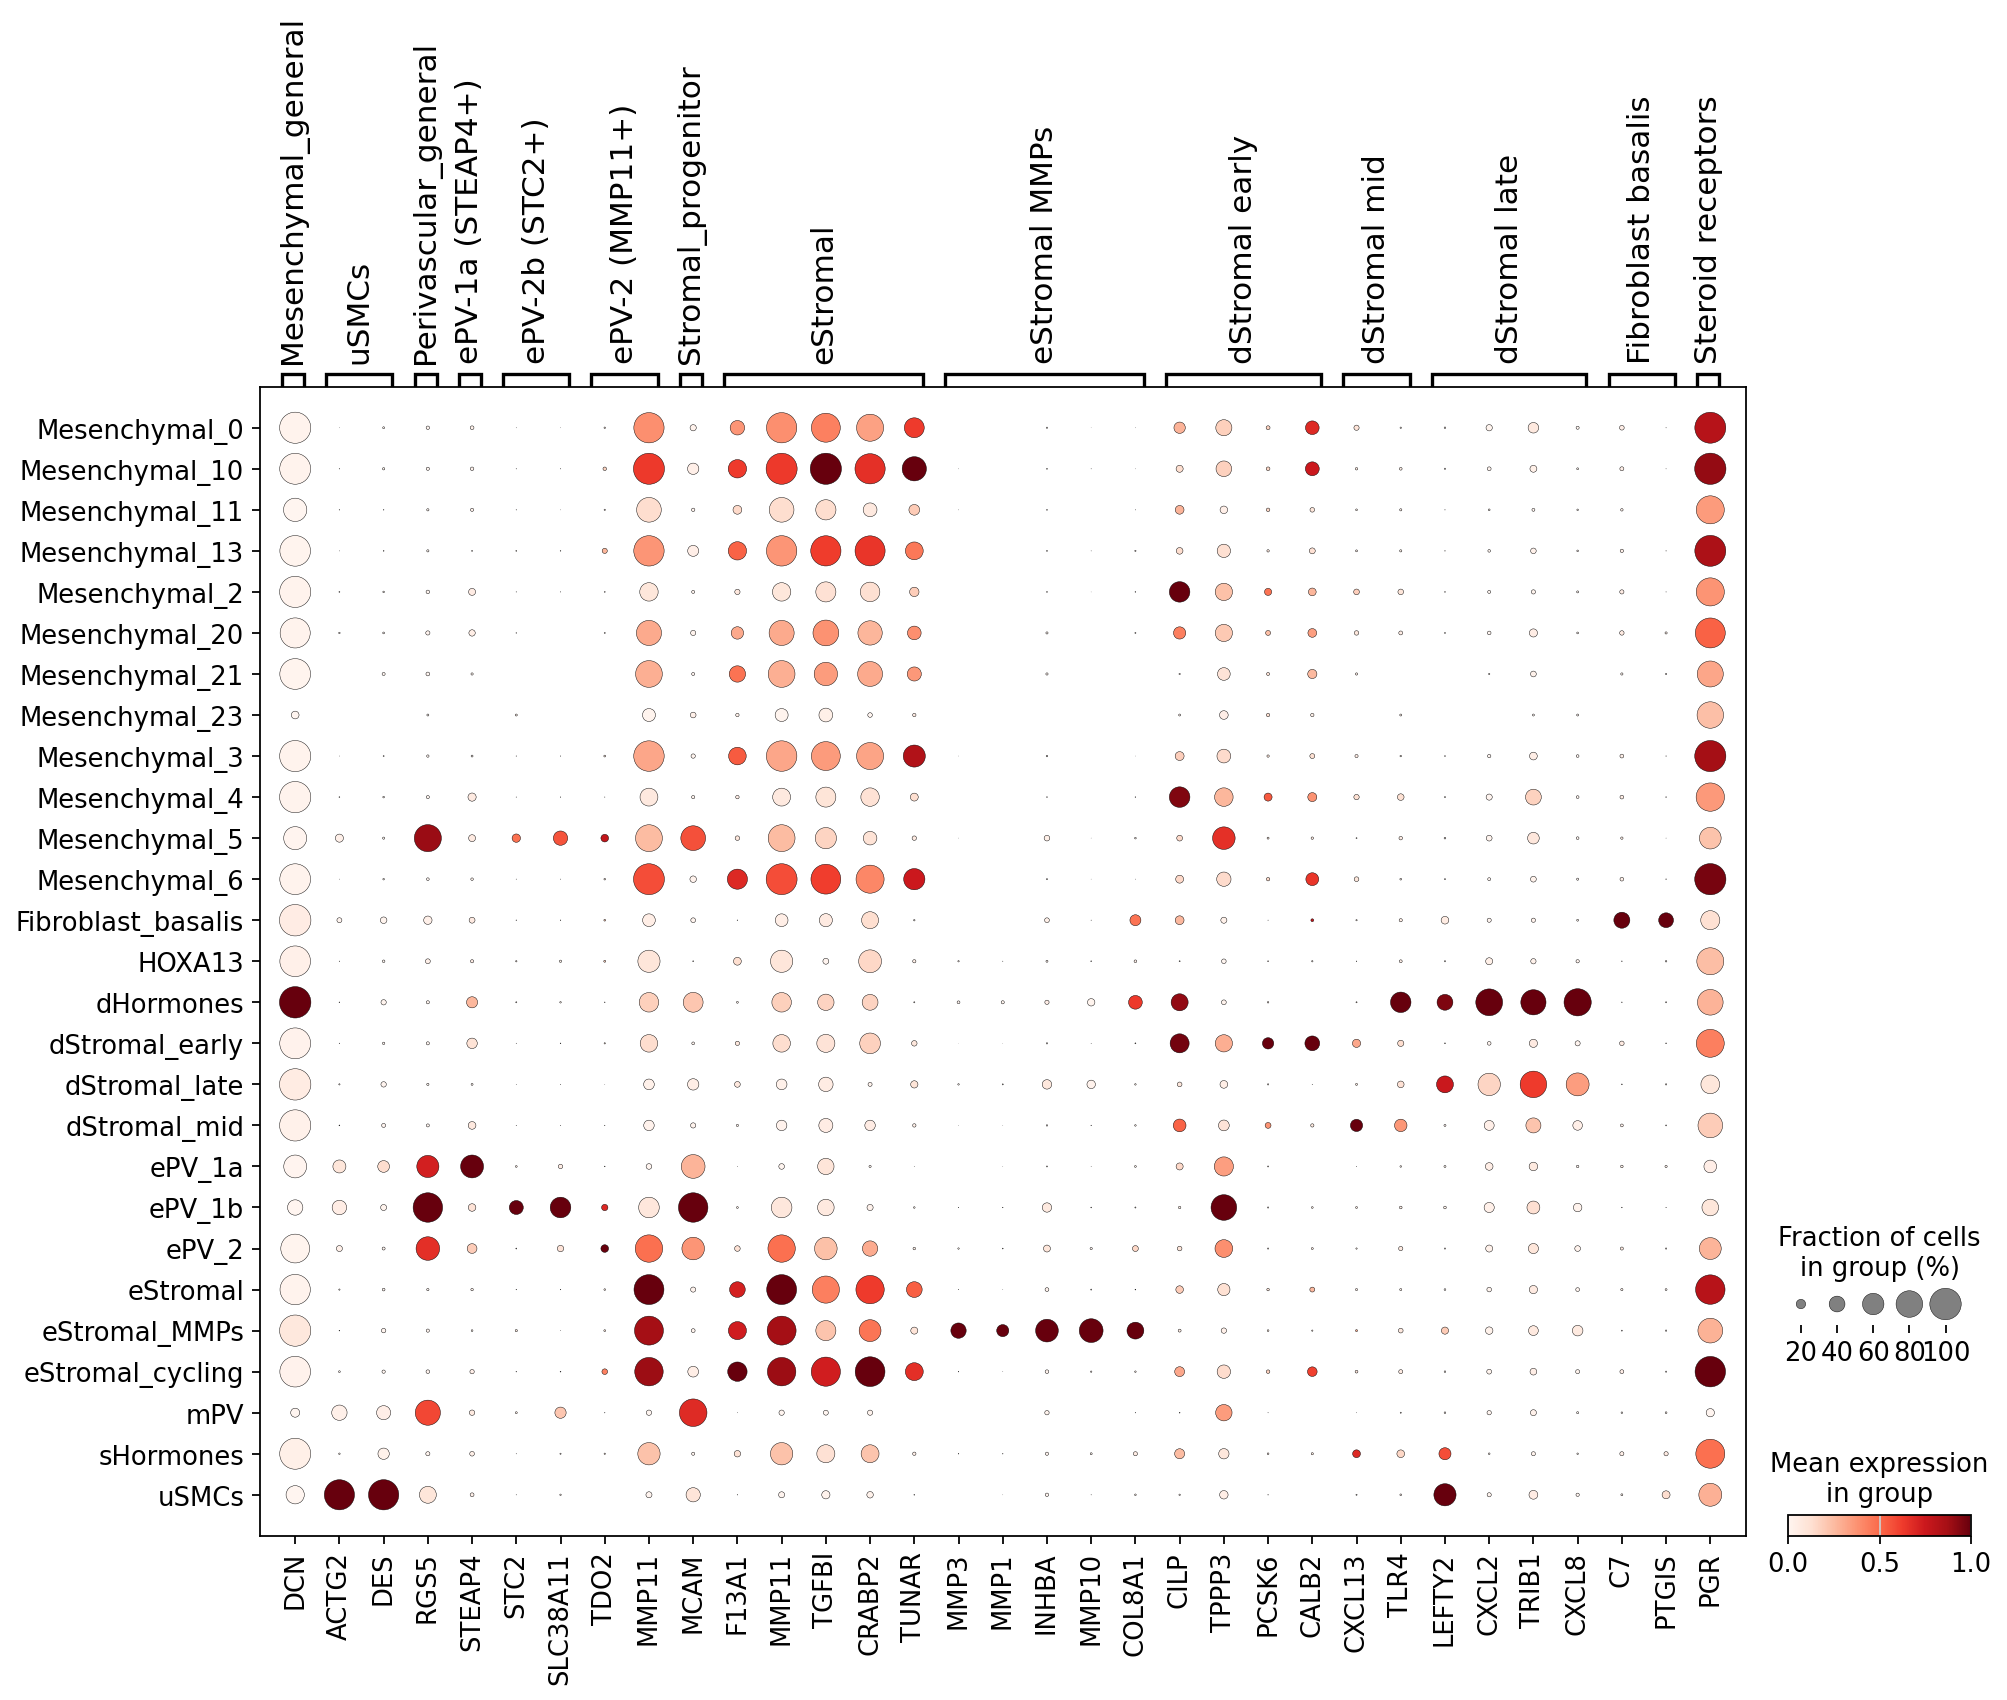

In [148]:
sc.pl.dotplot(mesen_full, 
              mesen_markers, 
              groupby = "ct_merged", 
              standard_scale = "var")

In [149]:
endothelial_markers = {
    'Endothelial_general':{'CDH5','VWF'},
    'Venous (ACKR1+)': {'ACKR1','TNC', 'CCL14'},
    'Arterial (SEMA3G+)':{'SEMA3G', 'GJA5','CXCR4'},
    'Lymphatic':{'RELN', 'PROX1', 'CCL21'},
}

In [150]:
endothelial_markers = filter_genes(endothelial_markers, adata_full)

In [151]:
endo_full = filter_by_lineage(adata_full, "Endothelial")

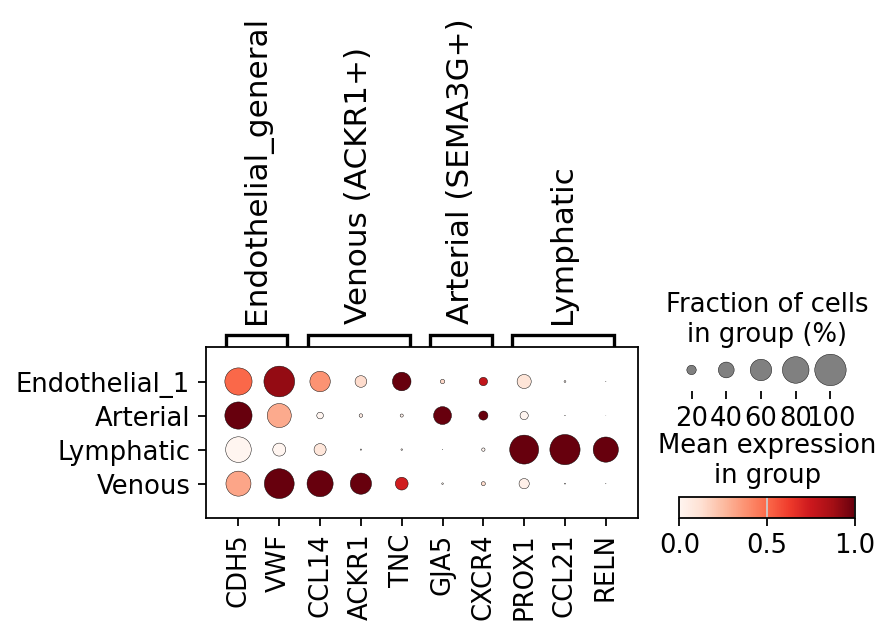

In [152]:
sc.pl.dotplot(endo_full, 
              endothelial_markers, 
              groupby = "ct_merged", 
              standard_scale = "var")

In [153]:
immune_markers = {
    'Immune': {'PTPRC'},
    'Lymphoid': {'CD3D', 'NKG7', 'CD69'},
    'Myeloid': {'CSF1R', 'CD14'},
    'B-cell': {'CD19',  'MS4A1', 'CD79B', 'IL6', 'IGHM'},  
    'Plasma B-cell': {'SDC1', 'CD27'}, #CD138 = SDC1 = Plasma cell marker. CD27 = memory B and plasma cell marker 
    'T-cell': {'CD3D', 'CD3G'}, #  'IL2RB', 'PTPRC', 'CD4', 'CD8A', 'IL7R', 
    'CD4 T-cell': {'CD4'},
    'CD8 T-cell': {'CD8A', 'CCL5', 'CD28'},
    'T-regs': {'FOXP3', 'IL2RA'},
    'uNK cell': {'ITGA1', 'CD9'}, # FCGR3A = CD16, so these are CD16-
    'uNK1': {'GZMA', 'ENTPD1', 'CYP26A1', 'B4GALNT1'},
    'uNK2': {'CD7', 'ANXA1', 'ITGB2'},
    'uNK3': {'CD160', 'KLRB1',  'GZMM', 'GZMB', 'GNLY'}, #IL7R, GZMB, GNLY negative, 'ITGAE', 'ITGAE', 'IL7R',
    'ILC3': {'CXCR4', 'SPINK2'},
    'Myeloid': {'CSF1R', 'CD14'},
    'Dendritic cell': {'CD1C', 'FOXJ2', 'ID2'}, 
    'cDC1': {'IRF8', 'BATF3'},
    'cDC2': {'CD1C'},   
    'Macropgage (all)': {'CD14', 'CD68', 'CSF1R', 'FCGR3A'},
    'uM1': {'EREG', 'IL1B'},
    'uM2': {'CD14', 'FOLR2', 'SELENOP', 'HMOX1'},
    'Monocytes': {'S100A12', 'S100A9'},
    'Mast cell': {'CPA3', 'KIT', 'CSF1'},
    'pDC': {'IL3RA', 'TCF4'},
    'RBC':{'HBB'},
    'Steroid receptors':{'PGR', 'ESR1'}
}

In [154]:
immune_markers = filter_genes(immune_markers)

No gene founds for CD4 T-cell


In [155]:
immune_full = filter_by_lineage(adata_full, "Immune")

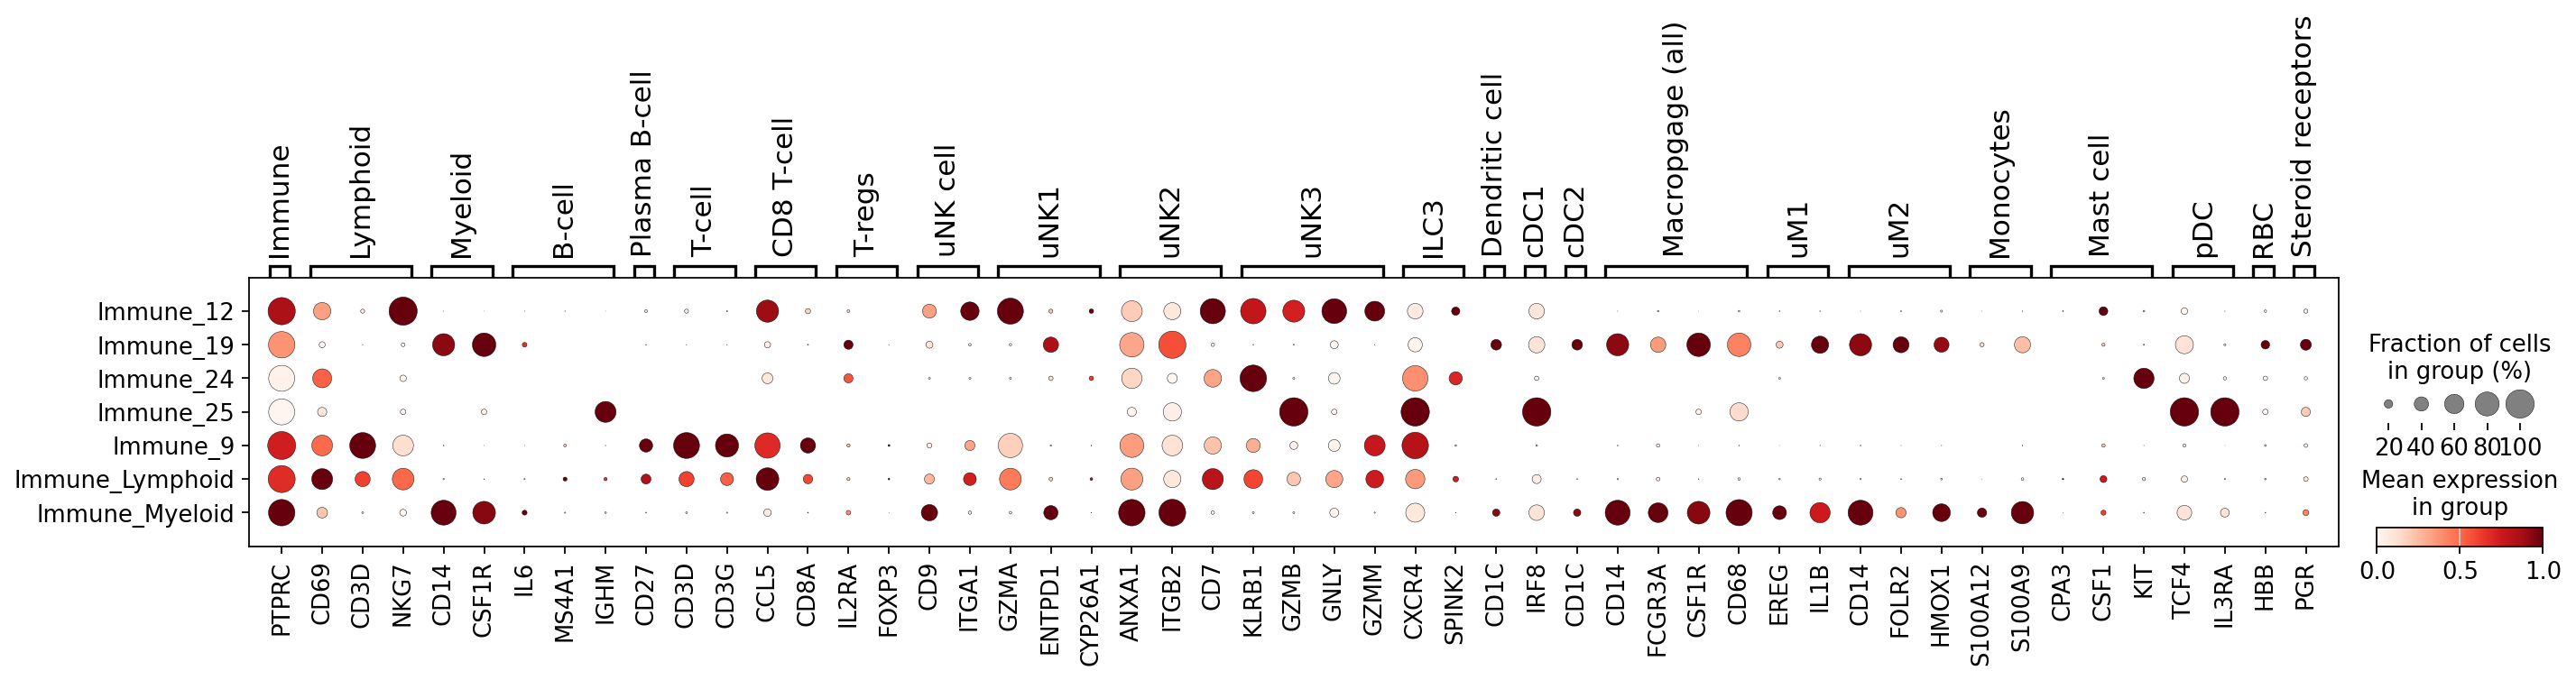

In [160]:
sc.pl.dotplot(immune_full, 
             immune_markers, 
             groupby = "ct_merged", 
             standard_scale = "var")

## A note on label transfer 

scANVI supports label transfer from reference to query dataset. It automatically learns a cell type classifier based on the scANVI embeddings. You can check the accuracy of the classifier on the predicted classifier  using the following code:

In [79]:
reference_latent = sc.AnnData(X = scanvae.get_latent_representation(),
                              obs = ref_adata.obs)
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.celltype)))

Acc: 0.7563750490388388


However, the scANVI classifier does not perform as well for a high number of fine-grained labels ([Xu 2021](https://www.embopress.org/doi/full/10.15252/msb.20209620), scANVI [documentation](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html)) as used in our dataset. Therefore we recommend using alternative strategies for label transfer, for example support vector machine classifier trained on HECA or manual annotation.